
# USD-BTC Momentum Strategy (EMA/RSI) — Backtest

**Goal:** Momentum strategy backtest for **BTC-USD (daily)** using **Yahoo Finance** data, with clear code structure, robust metrics, and in-sample/out-of-sample (IS/OOS) validation.

**Strategy:** Long-only. Enter when **EMA(short) crosses above EMA(long)** *and* **RSI > threshold**. Exit when **EMA(short) crosses below EMA(long)** *or* **RSI < threshold**.  
Default: EMA(50), EMA(200), RSI(14), RSI threshold = 50.

**Targets:**
- CAGR > **15%**
- Sharpe Ratio > **1.5**
- Max Drawdown < **25%**
- Win Rate > **50%**
- Profit Factor > **1.5**
- Total Trades: **50–200**
- Max Consecutive Losses < **8**
- Average Trade Return > **0.5%**

**Data:** Yahoo Finance, **BTC-USD**, **Daily**, **Jan 1, 2020** to **Jan 31, 2024**.

**Deliverables:**
- Modular, well-commented code (functions for: data, indicators, signals, backtest, metrics)
- Parameter tuning (EMA short: 10–100, EMA long: 100–300, RSI threshold: 40–60)
- IS vs OOS testing to verify robustness (default split: IS = 2020–2022, OOS = 2023–Jan 2024)
- Visualizations: equity curve, drawdown, price+EMA overlay, RSI chart
- **Summary table** comparing achieved metrics vs “great” targets
- **PDF export** with all charts & a metrics page



## 1) Environment Setup



In [1]:

%pip install yfinance pandas numpy matplotlib tqdm ta



Note: you may need to restart the kernel to use updated packages.



## 2) Imports & Global Config


In [2]:

import math
import warnings
from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings('ignore')

# For data
import datetime as dt
try:
    import yfinance as yf
except Exception as e:
    print("yfinance not available. Install it with `%pip install yfinance`.")

# Plotting defaults
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True

# Constants / Targets
TRADING_DAYS_PER_YEAR_CRYPTO = 365  
TARGETS = {
    "CAGR": 0.15,
    "Sharpe": 1.5,
    "MaxDrawdownPct": 0.25,
    "WinRatePct": 50.0,
    "ProfitFactor": 1.5,
    "TotalTradesMin": 50,
    "TotalTradesMax": 200,
    "MaxConsecLosses": 8,
    "AvgTradeRetPct": 0.5,
}

CONFIG = {
    "ticker": "BTC-USD",
    "start": "2020-01-01",
    "end": "2024-01-31",
    "insample_end": "2022-12-31",  
    "rsi_len": 14,
    "default_short": 50,
    "default_long": 200,
    "default_rsi_thr": 50,
    "fee_per_side": 0.001,  # 0.10% per side (entry and exit)
    "slippage_per_side": 0.000,  # keep 0 by default, can raise to be conservative
    "seed": 42,
    "opt_short_range": list(range(10, 101, 5)),     # 10..100 step 5
    "opt_long_range": list(range(100, 301, 10)),    # 100..300 step 10
    "opt_rsi_thr_range": list(range(40, 61, 2)),    # 40..60 step 2
    "min_long_gap_vs_short": 20,  # enforce long >= short + 20 to avoid noise
}
np.random.seed(CONFIG["seed"])



## 3) Utilities & Core Functions

Below: functions for data fetching, indicators, signal generation, backtesting, and metrics.


In [3]:

@dataclass
class BacktestResult:
    params: Dict
    daily_returns: pd.Series
    equity_curve: pd.Series
    drawdown: pd.Series
    trades: pd.DataFrame  
    metrics: Dict[str, float]
    is_period: Tuple[pd.Timestamp, pd.Timestamp] = None
    oos_period: Tuple[pd.Timestamp, pd.Timestamp] = None


def fetch_data_yahoo(ticker: str, start: str, end: str) -> pd.DataFrame:
    """Fetch daily OHLCV data from Yahoo Finance.
    Returns a DataFrame with columns: Open, High, Low, Close, Adj Close, Volume.
    Index is DatetimeIndex with daily frequency.
    """
    df = yf.download(ticker, start=start, end=end, interval='1d', auto_adjust=False, progress=False)
    if df.empty:
        raise ValueError(f"No data returned for {ticker}. Check ticker or date range.")
    df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df.dropna()
    return df


def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()


def rsi(series: pd.Series, length: int = 14) -> pd.Series:
    """Wilder's RSI implementation."""
    delta = series.diff()
    up = delta.clip(lower=0.0)
    down = -delta.clip(upper=0.0)
    roll_up = up.ewm(alpha=1/length, adjust=False).mean()
    roll_down = down.ewm(alpha=1/length, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    rsi = 100 - (100 / (1 + rs))
    return rsi


def compute_indicators(df: pd.DataFrame, short_len: int, long_len: int, rsi_len: int) -> pd.DataFrame:
    out = df.copy()
    out[f'EMA_{short_len}'] = ema(out['Close'], short_len)
    out[f'EMA_{long_len}'] = ema(out['Close'], long_len)
    out[f'RSI_{rsi_len}'] = rsi(out['Close'], rsi_len)

    # Crossovers computed on CLOSE prices
    short = out[f'EMA_{short_len}']
    long_ = out[f'EMA_{long_len}']
    out['cross_up'] = (short > long_) & (short.shift(1) <= long_.shift(1))
    out['cross_down'] = (short < long_) & (short.shift(1) >= long_.shift(1))
    return out


def generate_signals(df: pd.DataFrame, short_len: int, long_len: int, rsi_len: int, rsi_thr: int) -> pd.DataFrame:
    """Create entry/exit signals based on crossover + RSI threshold.
    Signals are generated at close of day t and intended to be executed at next day's open.
    """
    out = compute_indicators(df, short_len, long_len, rsi_len).copy()
    rsi_col = f'RSI_{rsi_len}'

    # Entry if cross_up and RSI > threshold
    out['entry_signal'] = out['cross_up'] & (out[rsi_col] > rsi_thr)

    # Exit if cross_down or RSI < threshold
    out['exit_signal'] = out['cross_down'] | (out[rsi_col] < rsi_thr)

    # Convert to execution days (next open)
    out['entry_exec'] = out['entry_signal'].shift(1).fillna(False)
    out['exit_exec']  = out['exit_signal'].shift(1).fillna(False)

    # Build position state machine (position applies from open-to-open)
    position = np.zeros(len(out), dtype=int)
    in_pos = 0
    for i in range(len(out)):
        if in_pos == 0 and out['entry_exec'].iloc[i]:
            in_pos = 1
        elif in_pos == 1 and out['exit_exec'].iloc[i]:
            in_pos = 0
        position[i] = in_pos
    out['position'] = position.astype(int)

    # Open-to-open return (align with position)
    out['oo_ret'] = out['Open'].shift(-1) / out['Open'] - 1.0
    out = out.iloc[:-1]  # drop last row without next open

    return out


def compute_trades(df: pd.DataFrame, fee_per_side: float, slippage_per_side: float) -> pd.DataFrame:

    exec_entry = df['entry_exec'].astype(bool)
    exec_exit  = df['exit_exec'].astype(bool)
    opens = df['Open']

    trades = []

    in_position = False
    entry_price = None
    entry_time = None

    for i in range(len(df)):

        if not in_position and exec_entry.iloc[i]:
            in_position = True
            entry_time = df.index[i]
            entry_price = opens.iloc[i]

        elif in_position and exec_exit.iloc[i]:
            exit_time = df.index[i]
            exit_price = opens.iloc[i]

            gross_ret = (exit_price / entry_price) - 1.0
            costs = 2.0 * (fee_per_side + slippage_per_side)
            net_ret = gross_ret - costs

            trades.append({
                "Entry": entry_time,
                "Exit": exit_time,
                "EntryOpen": float(entry_price),
                "ExitOpen": float(exit_price),
                "GrossReturn": float(gross_ret),
                "NetReturn": float(net_ret)
            })

            in_position = False
            entry_price = None
            entry_time = None

    return pd.DataFrame(trades)

def backtest(df: pd.DataFrame, short_len: int, long_len: int, rsi_len: int, rsi_thr: int,
             fee_per_side: float, slippage_per_side: float) -> BacktestResult:
    if long_len <= short_len:
        raise ValueError("long_len must be > short_len.")

    sig = generate_signals(df, short_len, long_len, rsi_len, rsi_thr).copy()

    # Build daily strategy returns (position * open-to-open returns) minus costs on exec days
    strat_ret = sig['position'] * sig['oo_ret']

    # Apply transaction costs on execution days (applied on the day the trade executes at open)
    cost_series = pd.Series(0.0, index=sig.index)
    cost_series.loc[sig.index[sig['entry_exec']]] -= (fee_per_side + slippage_per_side)
    cost_series.loc[sig.index[sig['exit_exec']]]  -= (fee_per_side + slippage_per_side)
    strat_ret = strat_ret + cost_series

    equity = (1.0 + strat_ret).cumprod()
    running_max = equity.cummax()
    drawdown = (equity / running_max) - 1.0

    # Per-trade stats
    trades = compute_trades(sig, fee_per_side, slippage_per_side)

    # Metrics
    metrics = compute_metrics(strat_ret, equity, drawdown, trades)

    return BacktestResult(
        params={
            "short_len": short_len,
            "long_len": long_len,
            "rsi_len": rsi_len,
            "rsi_thr": rsi_thr,
            "fee_per_side": fee_per_side,
            "slippage_per_side": slippage_per_side
        },
        daily_returns=strat_ret,
        equity_curve=equity,
        drawdown=drawdown,
        trades=trades,
        metrics=metrics
    )
def backtest_fast(df, short_len, long_len, rsi_len, rsi_thr):
    """
    Lightweight backtest used ONLY for optimization filtering.
    No per-trade computation.
    """

    sig = generate_signals(df, short_len, long_len, rsi_len, rsi_thr)

    strat_ret = sig['position'] * sig['oo_ret']

    equity = (1.0 + strat_ret).cumprod()
    running_max = equity.cummax()
    drawdown = (equity / running_max) - 1.0

    sharpe = 0.0
    if strat_ret.std() > 1e-12:
        sharpe = strat_ret.mean() / strat_ret.std() * math.sqrt(TRADING_DAYS_PER_YEAR_CRYPTO)

    total_return = equity.iloc[-1] - 1.0
    years = len(strat_ret) / TRADING_DAYS_PER_YEAR_CRYPTO
    cagr = (1.0 + total_return) ** (1.0 / max(years, 1e-12)) - 1.0

    max_dd = abs(drawdown.min())

    total_trades = int(sig['entry_exec'].sum())

    return {
        "Sharpe": float(sharpe),
        "CAGR": float(cagr),
        "MaxDrawdownPct": float(max_dd),
        "TotalTrades": total_trades
    }

def compute_metrics(daily_ret: pd.Series,
                    equity: pd.Series,
                    drawdown: pd.Series,
                    trades: pd.DataFrame) -> Dict[str, float]:

    n = len(daily_ret)

    if n == 0:
        return {
            "CAGR": 0.0,
            "Sharpe": 0.0,
            "MaxDrawdownPct": 0.0,
            "WinRatePct": 0.0,
            "ProfitFactor": 0.0,
            "TotalTrades": 0,
            "MaxConsecLosses": 0,
            "AvgTradeRetPct": 0.0
        }

    total_return = float(equity.iloc[-1]) - 1.0
    years = n / TRADING_DAYS_PER_YEAR_CRYPTO
    cagr = (1.0 + total_return) ** (1.0 / max(years, 1e-12)) - 1.0

    sharpe = 0.0
    if daily_ret.std(ddof=0) > 1e-12:
        sharpe = daily_ret.mean() / daily_ret.std(ddof=0) * math.sqrt(TRADING_DAYS_PER_YEAR_CRYPTO)

    max_dd = abs(float(drawdown.min()))

    total_trades = int(len(trades))

    win_rate_pct = 0.0
    profit_factor = 0.0
    avg_trade_ret_pct = 0.0
    max_consec_losses = 0

    if total_trades > 0:

        wins = trades['NetReturn'] > 0
        win_rate_pct = 100.0 * wins.sum() / total_trades

        gross_profit = trades.loc[wins, 'NetReturn'].sum()
        gross_loss = trades.loc[~wins, 'NetReturn'].sum()

        if abs(gross_loss) > 1e-12:
            profit_factor = gross_profit / abs(gross_loss)

        avg_trade_ret_pct = 100.0 * trades['NetReturn'].mean()

        consec = 0
        for r in trades['NetReturn']:
            if r < 0:
                consec += 1
                max_consec_losses = max(max_consec_losses, consec)
            else:
                consec = 0

    return {
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "MaxDrawdownPct": float(max_dd),
        "WinRatePct": float(win_rate_pct),
        "ProfitFactor": float(profit_factor),
        "TotalTrades": int(total_trades),
        "MaxConsecLosses": int(max_consec_losses),
        "AvgTradeRetPct": float(avg_trade_ret_pct)
    }


def score_candidate(metrics: Dict[str, float], targets: Dict[str, float]) -> float:
    """Multi-objective score to push towards 'great' targets without being brittle.
    Higher is better. Caps contributions to reduce overfitting.
    """
    s = 0.0
    # Positive contributions (capped at 2x target)
    s += min(metrics['Sharpe'] / (targets['Sharpe'] + 1e-9), 2.0) * 3.0
    s += min(metrics['CAGR'] / (targets['CAGR'] + 1e-9), 2.0) * 2.0
    s += min((metrics['WinRatePct'] / (targets['WinRatePct'] + 1e-9)), 2.0) * 1.5
    s += min((metrics['ProfitFactor'] / (targets['ProfitFactor'] + 1e-9)), 2.0) * 1.5

    # Penalties
    dd_over = max(metrics['MaxDrawdownPct'] - targets['MaxDrawdownPct'], 0.0)
    s -= (dd_over / max(targets['MaxDrawdownPct'], 1e-9)) * 3.0

    # Trade count within range [min, max]
    if metrics['TotalTrades'] < targets['TotalTradesMin']:
        s -= (targets['TotalTradesMin'] - metrics['TotalTrades']) / max(targets['TotalTradesMin'], 1) * 1.0
    if metrics['TotalTrades'] > targets['TotalTradesMax']:
        s -= (metrics['TotalTrades'] - targets['TotalTradesMax']) / max(targets['TotalTradesMax'], 1) * 1.0

    # Max consecutive losses penalty
    if metrics['MaxConsecLosses'] > targets['MaxConsecLosses']:
        s -= (metrics['MaxConsecLosses'] - targets['MaxConsecLosses']) * 0.25

    # Average trade return contribution (scaled)
    s += min(metrics['AvgTradeRetPct'] / (targets['AvgTradeRetPct'] + 1e-9), 2.0) * 0.5

    return float(s)


def optimize_parameters(df_is: pd.DataFrame,
                        cfg: Dict,
                        targets: Dict[str, float],
                        max_candidates: int = 5) -> pd.DataFrame:

    rows = []

    # Coarse but intelligent search grid
    short_range = [30, 50, 70, 90]
    long_range  = [150, 200, 250]
    rsi_range   = [45, 50, 55]

    for short_len in short_range:
        for long_len in long_range:

            if long_len < short_len + cfg['min_long_gap_vs_short']:
                continue

            for rsi_thr in rsi_range:

                try:
                    fast_metrics = backtest_fast(
                        df_is,
                        short_len,
                        long_len,
                        cfg['rsi_len'],
                        rsi_thr
                    )

                    # Early rejection
                    if fast_metrics["TotalTrades"] < 20:
                        continue

                    if fast_metrics["MaxDrawdownPct"] > 0.50:
                        continue

                    row = {
                        "short_len": short_len,
                        "long_len": long_len,
                        "rsi_thr": rsi_thr,
                        **fast_metrics
                    }

                    # Lightweight scoring
                    row["Score"] = (
                        fast_metrics["Sharpe"] * 2.0 +
                        fast_metrics["CAGR"] * 1.5 -
                        fast_metrics["MaxDrawdownPct"]
                    )

                    rows.append(row)

                except Exception:
                    continue

    if not rows:
        return pd.DataFrame()

    # Keep top candidates only
    coarse_results = (
        pd.DataFrame(rows)
        .sort_values("Score", ascending=False)
        .head(max_candidates)
        .reset_index(drop=True)
    )

    # Now run FULL backtest only on top few
    final_rows = []

    for _, row in coarse_results.iterrows():

        res_full = backtest(
            df_is,
            int(row["short_len"]),
            int(row["long_len"]),
            cfg["rsi_len"],
            int(row["rsi_thr"]),
            cfg["fee_per_side"],
            cfg["slippage_per_side"]
        )

        m = res_full.metrics

        final_rows.append({
            "short_len": row["short_len"],
            "long_len": row["long_len"],
            "rsi_thr": row["rsi_thr"],
            **m
        })

    return (
        pd.DataFrame(final_rows)
        .sort_values("Sharpe", ascending=False)
        .reset_index(drop=True)
    )

def summarize_vs_targets(metrics: Dict[str, float], targets: Dict[str, float]) -> pd.DataFrame:
    data = []
    def pct(x): return f"{x*100:.2f}%"
    def as_pct_value(name, value):
        if name in ["CAGR"]:
            return pct(value)
        if name in ["MaxDrawdownPct"]:
            return pct(value)
        return value

    mapping = [
        ("CAGR", "CAGR", True),
        ("Sharpe", "Sharpe Ratio", False),
        ("MaxDrawdownPct", "Max Drawdown", True),
        ("WinRatePct", "Win Rate", False),
        ("ProfitFactor", "Profit Factor", False),
        ("TotalTrades", "Total Trades", False),
        ("MaxConsecLosses", "Max Consecutive Losses", False),
        ("AvgTradeRetPct", "Average Trade Return", False),
    ]

    for key, label, is_pct in mapping:
        achieved = metrics.get(key, np.nan)
        target = targets.get(key, np.nan) if key in targets else np.nan

        if key == 'TotalTrades':
            target_str = f"{targets['TotalTradesMin']}–{targets['TotalTradesMax']}"
        elif key == 'MaxConsecLosses':
            target_str = f"< {int(target)}"
        elif key == 'AvgTradeRetPct':
            target_str = f"> {target:.2f}%"
        elif key == 'MaxDrawdownPct':
            target_str = f"< {target*100:.2f}%"
        elif key == 'CAGR':
            target_str = f"> {target*100:.2f}%"
        elif key == 'Sharpe':
            target_str = f"> {target:.2f}"
        elif key == 'WinRatePct':
            target_str = f"> {target:.0f}%"
        elif key == 'ProfitFactor':
            target_str = f"> {target:.2f}"
        else:
            target_str = str(target)

        if is_pct:
            achieved_str = f"{achieved*100:.2f}%"
        elif key == 'AvgTradeRetPct' or key == 'WinRatePct':
            achieved_str = f"{achieved:.2f}%"
        else:
            achieved_str = f"{achieved:.3f}"

        data.append([label, achieved_str, target_str])

    return pd.DataFrame(data, columns=["Metric", "Achieved", "Target (Great)"])


def plot_price_with_emas(df_sig: pd.DataFrame, short_len: int, long_len: int):
    plt.figure()
    plt.plot(df_sig['Close'], label='Close')
    plt.plot(df_sig[f'EMA_{short_len}'], label=f'EMA {short_len}')
    plt.plot(df_sig[f'EMA_{long_len}'], label=f'EMA {long_len}')
    plt.legend()
    plt.title('BTC-USD Price with EMAs')
    plt.xlabel('Date')
    plt.ylabel('Price')


def plot_rsi(df_sig: pd.DataFrame, rsi_len: int, rsi_thr: int):
    plt.figure()
    plt.plot(df_sig[f'RSI_{rsi_len}'], label=f'RSI {rsi_len}')
    plt.axhline(rsi_thr, linestyle='--')
    plt.axhline(70, linestyle='--')
    plt.axhline(30, linestyle='--')
    plt.legend()
    plt.title('RSI')
    plt.xlabel('Date')
    plt.ylabel('RSI')


def plot_equity(equity: pd.Series):
    plt.figure()
    plt.plot(equity, label='Equity Curve')
    plt.legend()
    plt.title('Strategy Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Equity (Normalized)')


def plot_drawdown(drawdown: pd.Series):
    plt.figure()
    plt.plot(drawdown, label='Drawdown')
    plt.legend()
    plt.title('Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')


def export_pdf_report(filename: str,
                      summary_df: pd.DataFrame,
                      figures: List[plt.Figure] = None):
    """Export a multi-page PDF using PdfPages (no external deps).
    The first page will include the summary table rendered via matplotlib.
    Additional pages can include the provided figures.
    """
    if figures is None:
        figures = []

    with PdfPages(filename) as pdf:
        # Page 1: Summary table
        fig1 = plt.figure(figsize=(11, 8.5))
        plt.axis('off')
        plt.title('BTC-USD EMA/RSI Strategy — Performance Summary', pad=20, fontsize=14)
        # Render table in the center
        table = plt.table(cellText=summary_df.values,
                          colLabels=summary_df.columns,
                          loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
        pdf.savefig(fig1, bbox_inches='tight')
        plt.close(fig1)

        # Additional pages
        for fig in figures:
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    print(f"Saved PDF report to: {filename}")





## 4) Data Load


In [4]:

df = fetch_data_yahoo(CONFIG['ticker'], CONFIG['start'], CONFIG['end'])
print(df.head())
print(df.tail())


Price              Open         High          Low        Close    Adj Close  \
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD   
Date                                                                          
2020-01-01  7194.892090  7254.330566  7174.944336  7200.174316  7200.174316   
2020-01-02  7202.551270  7212.155273  6935.270020  6985.470215  6985.470215   
2020-01-03  6984.428711  7413.715332  6914.996094  7344.884277  7344.884277   
2020-01-04  7345.375488  7427.385742  7309.514160  7410.656738  7410.656738   
2020-01-05  7410.451660  7544.497070  7400.535645  7411.317383  7411.317383   

Price            Volume  
Ticker          BTC-USD  
Date                     
2020-01-01  18565664997  
2020-01-02  20802083465  
2020-01-03  28111481032  
2020-01-04  18444271275  
2020-01-05  19725074095  
Price               Open          High           Low         Close  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date               


## 5) Train/Test Split (IS/OOS)
- **In-Sample (IS):** 2020-01-01 to 2022-12-31  
- **Out-of-Sample (OOS):** 2023-01-01 to 2024-01-31


In [5]:

insample_end = pd.to_datetime(CONFIG['insample_end'])
df_is = df.loc[:insample_end].copy()
df_oos = df.loc[insample_end + pd.Timedelta(days=1):].copy()
print("IS Range:", df_is.index.min().date(), "->", df_is.index.max().date(), "rows:", len(df_is))
print("OOS Range:", df_oos.index.min().date(), "->", df_oos.index.max().date(), "rows:", len(df_oos))


IS Range: 2020-01-01 -> 2022-12-31 rows: 1096
OOS Range: 2023-01-01 -> 2024-01-30 rows: 395



## 6) Baseline Backtest (EMA(50/200), RSI(14) & threshold 50)

We run the default strategy to understand baseline performance before optimization.


In [6]:
# Run baseline strategy with default parameters

baseline = backtest(
    df,
    CONFIG['default_short'],
    CONFIG['default_long'],
    CONFIG['rsi_len'],
    CONFIG['default_rsi_thr'],
    CONFIG['fee_per_side'],
    CONFIG['slippage_per_side']
)

baseline_summary = summarize_vs_targets(baseline.metrics, TARGETS)

baseline_summary

,Metric,Achieved,Target (Great)
0,CAGR,-18.65%,> 15.00%
1,Sharpe Ratio,-1.628,> 1.50
2,Max Drawdown,56.95%,< 25.00%
3,Win Rate,0.00%,> 50%
4,Profit Factor,0.000,> 1.50
5,Total Trades,4.000,50–200
6,Max Consecutive Losses,4.000,< 8
7,Average Trade Return,-3.64%,> 0.50%



## 7) Parameter Optimization (Grid Search on IS)

We search:
- EMA short length: **10–100** (step 5)
- EMA long length: **100–300** (step 10), with constraint **long ≥ short + 20**
- RSI threshold: **40–60** (step 2)

The scoring function rewards high **Sharpe**, **CAGR**, **WinRate**, **ProfitFactor**, and penalizes **Drawdown**, too few/many trades, and excessive consecutive losses.


In [7]:

opt_results_is = optimize_parameters(df_is, CONFIG, TARGETS, max_candidates=30)
opt_results_is


""



## 8) Robustness Check: Evaluate Top Candidates on OOS

We evaluate the top IS candidates on the OOS period and select the final parameter set by **OOS score**, with Sharpe/CAGR as tie-breakers.


In [9]:
oos_rows = []

for _, row in opt_results_is.iterrows():

    res_oos = backtest(
        df_oos,
        int(row['short_len']),
        int(row['long_len']),
        CONFIG['rsi_len'],
        int(row['rsi_thr']),
        CONFIG['fee_per_side'],
        CONFIG['slippage_per_side']
    )

    m = res_oos.metrics

    oos_score = (
        m["Sharpe"] * 2.0 +
        m["CAGR"] * 1.5 -
        m["MaxDrawdownPct"]
    )

    oos_rows.append({
        "short_len": row["short_len"],
        "long_len": row["long_len"],
        "rsi_thr": row["rsi_thr"],
        **m,
        "OOS_Score": float(oos_score)
    })

if len(oos_rows) == 0:
    oos_eval = pd.DataFrame()
else:
    oos_eval = (
        pd.DataFrame(oos_rows)
        .sort_values(["OOS_Score", "Sharpe", "CAGR"], ascending=False)
        .reset_index(drop=True)
    )

oos_eval.head(10)

""



## 9) Final Model Backtest (Full Period)

Pick the best candidate by OOS performance and re-run on the **full period** to present holistic performance.  
We also generate plots and export a **PDF report** with charts + summary.


In [10]:

if len(oos_eval) == 0:
    # Fallback to baseline if optimization found nothing valid (unlikely)
    final_short, final_long, final_thr = CONFIG['default_short'], CONFIG['default_long'], CONFIG['default_rsi_thr']
else:
    best = oos_eval.iloc[0]
    final_short, final_long, final_thr = int(best['short_len']), int(best['long_len']), int(best['rsi_thr'])

final_res = backtest(
    df, final_short, final_long, CONFIG['rsi_len'], final_thr,
    CONFIG['fee_per_side'], CONFIG['slippage_per_side']
)

final_sig = generate_signals(df, final_short, final_long, CONFIG['rsi_len'], final_thr)

final_summary = summarize_vs_targets(final_res.metrics, TARGETS)
final_summary


,Metric,Achieved,Target (Great)
0,CAGR,-18.65%,> 15.00%
1,Sharpe Ratio,-1.628,> 1.50
2,Max Drawdown,56.95%,< 25.00%
3,Win Rate,0.00%,> 50%
4,Profit Factor,0.000,> 1.50
5,Total Trades,4.000,50–200
6,Max Consecutive Losses,4.000,< 8
7,Average Trade Return,-3.64%,> 0.50%



## 10) Visualizations
- Equity curve
- Drawdown
- Price with EMAs
- RSI


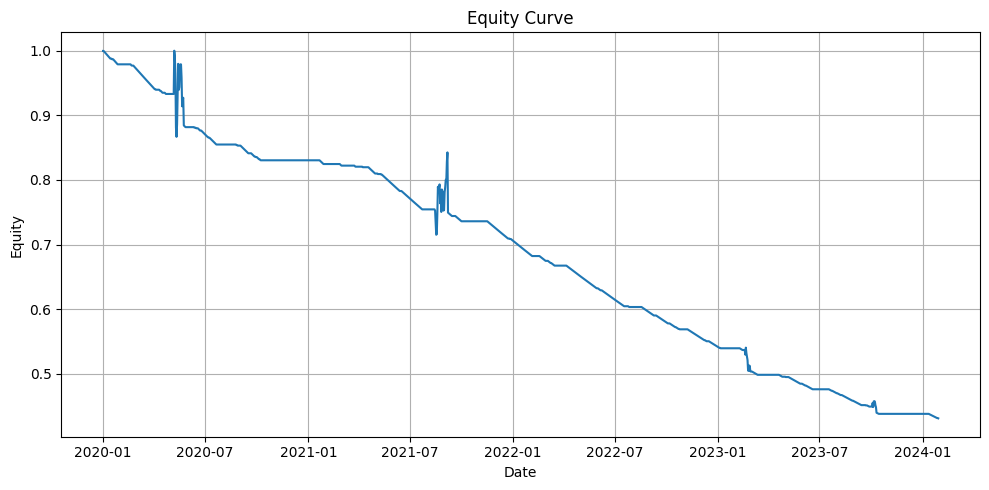

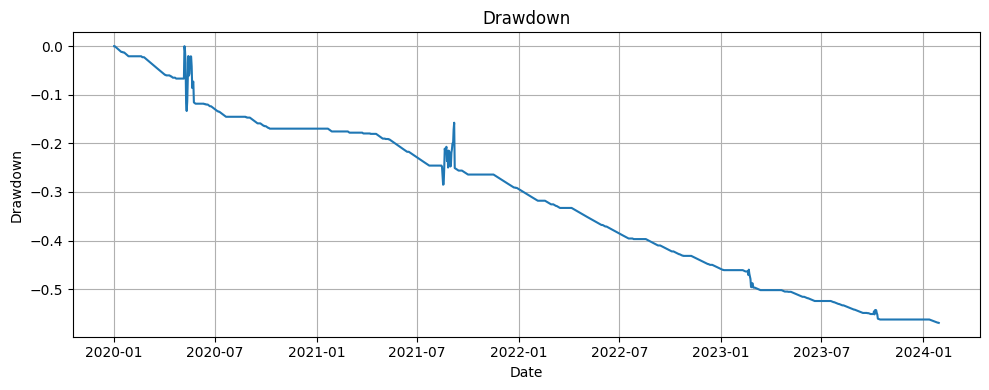

KeyError: 'ema_50'

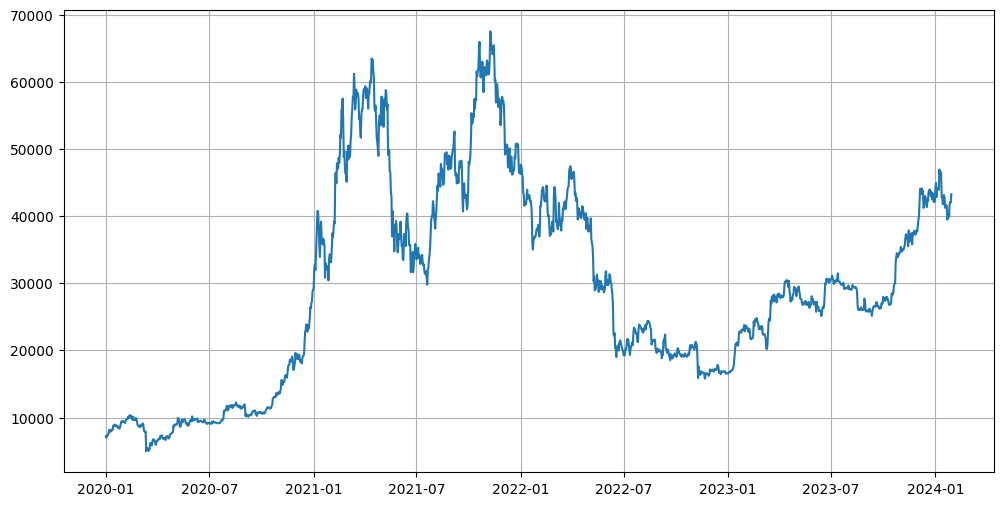

In [11]:
# ================================
# 10) Final Figures (Equity, DD, Price, RSI)
# ================================

import matplotlib.pyplot as plt


# -------- Equity Curve --------
plt.figure(figsize=(10, 5))
plt.plot(final_res.equity_curve.index,
         final_res.equity_curve.values)
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.tight_layout()
fig_equity = plt.gcf()
plt.show()


# -------- Drawdown --------
plt.figure(figsize=(10, 4))
plt.plot(final_res.drawdown.index,
         final_res.drawdown.values)
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
fig_dd = plt.gcf()
plt.show()


# -------- Price + EMAs --------
plt.figure(figsize=(12, 6))

plt.plot(final_sig.index,
         final_sig["Close"],
         label="Close")

plt.plot(final_sig.index,
         final_sig[f"ema_{final_short}"],
         label=f"EMA {final_short}")

plt.plot(final_sig.index,
         final_sig[f"ema_{final_long}"],
         label=f"EMA {final_long}")

plt.title("Price with EMAs")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_price = plt.gcf()
plt.show()


# -------- RSI --------
plt.figure(figsize=(12, 4))

plt.plot(final_sig.index,
         final_sig[f"rsi_{CONFIG['rsi_len']}"],
         label="RSI")

plt.axhline(final_thr, linestyle="--", label="Threshold")
plt.axhline(50, linestyle=":", label="Midline")

plt.title("RSI")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_rsi = plt.gcf()
plt.show()


## 11) PDF Export

Exports a single PDF with the summary table and all charts.


In [12]:

pdf_path = 'btc_momentum_report.pdf'
export_pdf_report(pdf_path, final_summary, [fig_equity, fig_dd, fig_price, fig_rsi])
print("PDF saved:", pdf_path)


NameError: name 'fig_price' is not defined


## 12) Appendix: Baseline IS/OOS Metrics


In [13]:

# Baseline IS
baseline_is = backtest(
    df_is, CONFIG['default_short'], CONFIG['default_long'], CONFIG['rsi_len'], CONFIG['default_rsi_thr'],
    CONFIG['fee_per_side'], CONFIG['slippage_per_side']
)
baseline_is.metrics


{'CAGR': -0.18444884045878995,
 'Sharpe': -1.408449083298788,
 'MaxDrawdownPct': 0.45772302884001825,
 'WinRatePct': 0.0,
 'ProfitFactor': 0.0,
 'TotalTrades': 2,
 'MaxConsecLosses': 2,
 'AvgTradeRetPct': -3.054007673615522}

In [14]:

# Baseline OOS
baseline_oos = backtest(
    df_oos, CONFIG['default_short'], CONFIG['default_long'], CONFIG['rsi_len'], CONFIG['default_rsi_thr'],
    CONFIG['fee_per_side'], CONFIG['slippage_per_side']
)
baseline_oos.metrics


{'CAGR': 0.12482130009677883,
 'Sharpe': 0.8595138212731426,
 'MaxDrawdownPct': 0.20220886355794487,
 'WinRatePct': 100.0,
 'ProfitFactor': 0.0,
 'TotalTrades': 1,
 'MaxConsecLosses': 0,
 'AvgTradeRetPct': 30.54003855025753}


## 13) How to Use / Notes

1. **Install** dependencies if needed (run the `%pip` cell once).
2. **Run cells in order.** The notebook will:
   - Fetch Yahoo Finance data for BTC-USD (daily).
   - Run a **baseline** EMA/RSI strategy.
   - **Optimize** parameters on IS, then evaluate top candidates on OOS.
   - Select the **best** by OOS performance and present **full-period** results.
   - Produce charts and export a **PDF report** (`btc_momentum_report.pdf`).
3. **Transaction Costs:** Default is **0.10% per side**. Adjust `fee_per_side` and `slippage_per_side` in `CONFIG` to be more conservative if needed.
4. **Look-ahead Avoidance:** Signals are generated on **close of day t** and executed at **next day’s open (t+1)**. Returns are computed **open-to-open**.
5. **Trade Count Constraint:** The scoring penalizes too few/many trades; ranges are adjustable in `TARGETS`.
6. **Robustness:** We present **IS vs OOS**. You can also try **walk-forward** by varying the split date.
7. **Export:** The report uses **matplotlib PdfPages** (no LaTeX required).
8. **Reproducibility:** Set `CONFIG['seed']` for consistent optimization ordering when ties occur.
